# Библиотеки

In [6]:
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py -O vocab.py

--2025-03-20 16:30:20--  https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2879 (2.8K) [text/plain]
Saving to: ‘vocab.py’

vocab.py            100%[===================>]   2.81K  --.-KB/s    in 0s      

2025-03-20 16:30:20 (38.5 MB/s) - ‘vocab.py’ saved [2879/2879]



In [7]:
!pip install subword-nmt

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from sklearn.model_selection import train_test_split
from vocab import Vocab

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from tqdm import tqdm, trange

from torch.optim.lr_scheduler import ReduceLROnPlateau

from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

import re

%matplotlib inline

In [9]:
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt

--2025-03-20 16:30:24--  https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1 [following]
--2025-03-20 16:30:24--  https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1aeeac3bddb4afc41915c90809.dl.dropboxusercontent.com/cd/0/inline/CmN0lFnSMiTFs4aDchlLTq_rneNjWa-7syo3p7h2BB4vT1H5RO1VFZGpp_GJ7Lq1gygsAUkdbbbxQKSnI5KscG165FBuAQuneHIno4XnaDyDatlq-_yE0sqoVJfGb8mnR5U/file?dl=1# [following]
--2025-03-20 16:30:24--  https://uc1aeeac3bddb4afc41915c90809.dl.dropboxusercontent.com/cd/0/inline/CmN0lFnSMiTFs4

# Машинный перевод

Попробуем решить задачу машинного перевода с русского на английский. В частности, будем работать с описаниями отелей.

Прежде чем перейти к  реализации архитектуры, необходимо выполнить некоторую предварительную обработку - токенизацию.

Данные содержат уникальные редкие слова. Если мы работаем на уровне слов, нам придется иметь дело с большим словарем. Если вместо этого мы будем использовать модели на уровне отдельных символов, для обработки последовательности потребуется много итераций. На этот раз мы выберем нечто среднее.

Один из популярных подходов называется [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) , также известный как BPE. Алгоритм начинается с токенизации на уровне символов, а затем итеративно объединяет наиболее часто встречающиеся пары в течение N итераций. Это приводит к тому, что часто встречающиеся слова объединяются в один токен, а редкие слова разбиваются на слоги или даже символы.




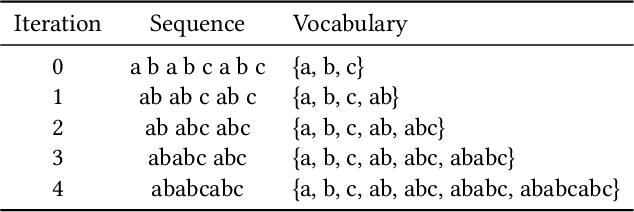

**Архитектура encoder-decoder для машинного перевода**


![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)

### Подгрузка данных

In [10]:
with open('data.txt') as f:
  print(f.readlines()[0])

Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.	Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.



### **BPE + Построение словарей**

[Subword Neural Machine Translation](https://github.com/rsennrich/subword-nmt) - Unsupervised Word Segmentation for Neural Machine Translation and Text Generation

In [11]:
tokenizer = WordPunctTokenizer()

def tokenize(x):
  return ' '.join(tokenizer.tokenize(x.lower()))

In [12]:
def process_data(num_symbols=8000, test_size=3000, random_state=2023):

    # Чтение и запись токенизированных данных
    with open('train.en', 'w') as f_src, open('train.ru', 'w') as f_dst:
        for line in open('data.txt'):
            src_line, dst_line = line.strip().split('\t')
            f_src.write(tokenize(src_line) + '\n')
            f_dst.write(tokenize(dst_line) + '\n')

    # Обучение BPE
    bpe = {}
    for lang in ['en', 'ru']:
        learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=num_symbols)
        bpe[lang] = BPE(open('./bpe_rules.' + lang))

        with open('train.bpe.' + lang, 'w') as f_out:
            for line in open('train.' + lang):
                f_out.write(bpe[lang].process_line(line.strip()) + '\n')

    # Загрузка данных после BPE
    data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
    data_out = np.array(open('./train.bpe.en').read().split('\n'))

    # Разделение на обучающую и валидационную выборки
    train_inp, dev_inp, train_out, dev_out = train_test_split(
        data_inp,
        data_out,
        test_size=test_size,
        random_state=random_state,
    )

    # Примеры данных
    for i in range(3):
        print('inp:', train_inp[i])
        print('out:', train_out[i], end='\n\n')

    # Создание словарей
    inp_voc = Vocab.from_lines(train_inp)
    out_voc = Vocab.from_lines(train_out)

    # Пример работы с батчем
    batch_lines = sorted(train_inp, key=len)[5:10]
    batch_ids = inp_voc.to_matrix(batch_lines)
    batch_lines_restored = inp_voc.to_lines(batch_ids)

    print("lines")
    print(batch_lines)
    print("\nwords to ids (0 = bos, 1 = eos):")
    print(batch_ids)
    print("\nback to words")
    print(batch_lines_restored)

    # Визуализация длины предложений
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.title("source length")
    plt.hist(list(map(len, map(str.split, train_inp))), bins=20)

    plt.subplot(1, 2, 2)
    plt.title("translation length")
    plt.hist(list(map(len, map(str.split, train_out))), bins=20)

    plt.show()

    return train_inp, dev_inp, train_out, dev_out, inp_voc, out_voc

100%|██████████| 8000/8000 [00:09<00:00, 849.45it/s] 


inp: этот отель находится в центре парижа , в 2 минутах от площади республики и станции метро с 5 лини@@ ями метро и 4 автобус@@ ными маршру@@ тами .
out: this hotel is located in the centre of paris , 2 minutes from place de la ré@@ pub@@ li@@ que and its metro station , which offers 5 metro lines and 4 bus lines .

inp: на полностью оборудованной мини - кухне можно самостоятельно готовить .
out: there is a full kitchenette where guests are welcome to prepare their meals .

inp: номера находятся под кры@@ шей или на ниж@@ них эта@@ жах с эр@@ ке@@ рами с видом на сад .
out: set under the roof or on the lower floors with bay windows looking out onto the park , they are all equipped with wi - fi access .

lines
['гостевой дом r .', 'имеется балкон .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1109,   29,    1,    1,    1],
        [   0, 3486, 1869,   29,    1,    1,    1,    1],
        [   0, 2922, 18

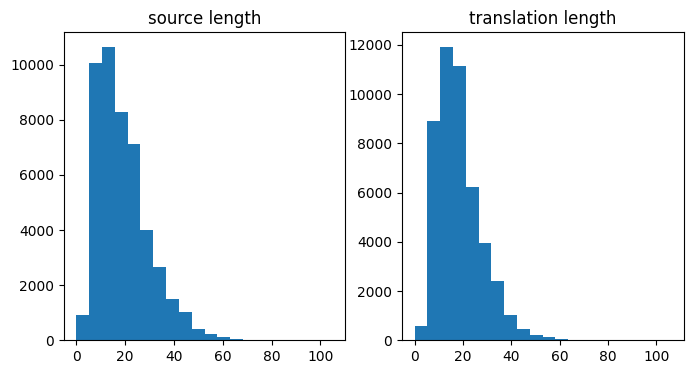

In [13]:
train_inp, dev_inp, train_out, dev_out, inp_voc, out_voc = process_data()

### **Encoder-decoder model**


In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
device

'cuda'

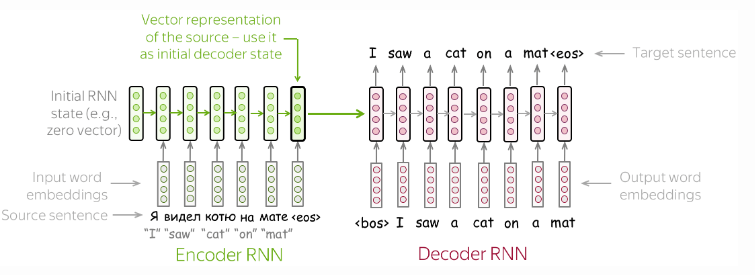

In [16]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        # enc_seq: [batch, sequence length, hid_size], last_state: [batch, hid_size]

        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]
        prev_emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(prev_emb, prev_gru0_state) # input & hidden states
        output_logits = self.logits(new_dec_state)

        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

### Loss

Будем минимизировать categorical crossentropy во время обучения на данных $D$:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

$|D|$ - длина всех последовательностей, включая BOS and первые EOS токены, кроме PAD

In [17]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy

    # average cross-entropy over tokens where mask == True
    return -logp_out[mask].mean()

### Оценка качества: BLEU

Распространенная матрика машинного перевода - [BLEU](https://en.wikipedia.org/wiki/BLEU). Эта метрика вычисляет долю верно предсказанных n-grams. В частности, например, для n=1, 2, 3, 4 она вычисляется как геометрическое среднее со штрафом за короткие переводы.

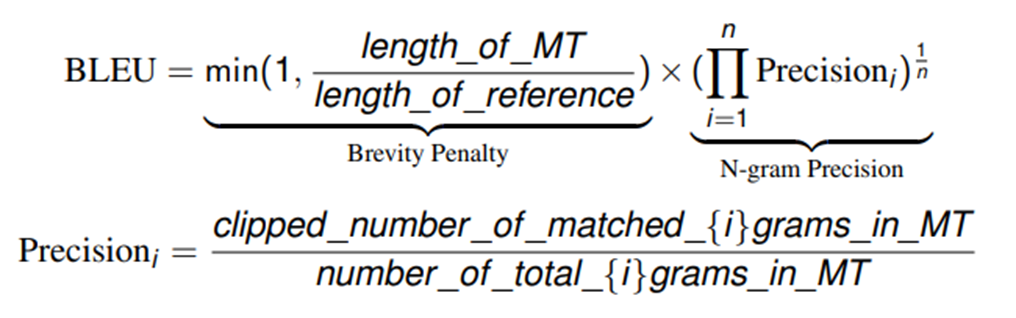

[Эволюция метрик качества машинного перевода](https://habr.com/ru/articles/745642/)

In [18]:
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

### **Attention**

Добавим простой attention:

Имея последовательность $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ из encoder'а и decoder state $h^d$,

* Вычислим логиты двухслойной сеткой
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Получим вероятности,
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Взвесим состояния encoder'а с вероятностями, чтобы получить **attention**
$$ attn = \sum_t p_t \cdot h^e_t $$

[Attention and Augmented Recurrent Neural Networks](https://distill.pub/2016/augmented-rnns/).

In [19]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units

        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        batch_size, ninp, enc_size = enc.shape

        # Compute logits
        x = self.linear_dec(dec).reshape(-1, 1, self.hid_size)
        x = torch.tanh(self.linear_enc(enc) + x)
        x = self.linear_out(x)

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need torch.where
        x[torch.where(inp_mask == False)] = -1e9

        # Compute attention probabilities (softmax)
        probs = self.softmax(x.reshape(batch_size, ninp))

        # Compute attention response using enc and probs
        attn = (probs.reshape(batch_size, ninp, 1) * enc).sum(1)

        return attn, probs

### **Seq2seq model + attention**

Теперь можно использовать слой attention в Seq2Seq модели:
![img](https://i.imgur.com/6fKHlHb.png)
_image from distill.pub [article](https://distill.pub/2016/augmented-rnns/)_

На каждом шагу используем предыдущее состояние декодера для подсчета attention, затем приконкатенируем attention ко входам следующего слоя.


In [20]:
class AttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.enc0 = nn.LSTM(emb_size, hid_size, num_layers=2, batch_first=True)
        self.dec_start = nn.Linear(hid_size, hid_size)

        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attention = AttentionLayer(hid_size, hid_size, attn_size)


    def encode(self, inp, **flags):
        """
        Takes input sequences, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        #[dec_start] = super().encode(inp, **flags)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        dec_start = self.dec_start(last_state)

        # apply attention layer from initial decoder hidden state
        inp_mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)

        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor

        first_state = [dec_start, enc_seq, inp_mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """

        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)

        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)
        x = self.dec0(x, prev_gru0_state)

        new_dec_state = [x, enc_seq, enc_mask, attn_probs]
        output_logits = self.logits(x)
        return [new_dec_state, output_logits]


### Training loop - модель с Attention


In [17]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

In [ ]:
model

AttentiveModel(
  (emb_inp): Embedding(8047, 64)
  (emb_out): Embedding(7800, 64)
  (enc0): LSTM(64, 128, num_layers=2, batch_first=True)
  (dec_start): Linear(in_features=128, out_features=128, bias=True)
  (dec0): GRUCell(192, 128)
  (logits): Linear(in_features=128, out_features=7800, bias=True)
  (attention): AttentionLayer(
    (linear_enc): Linear(in_features=128, out_features=128, bias=True)
    (linear_dec): Linear(in_features=128, out_features=128, bias=True)
    (linear_out): Linear(in_features=128, out_features=1, bias=True)
    (softmax): Softmax(dim=-1)
  )
)

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.0020633142012208075

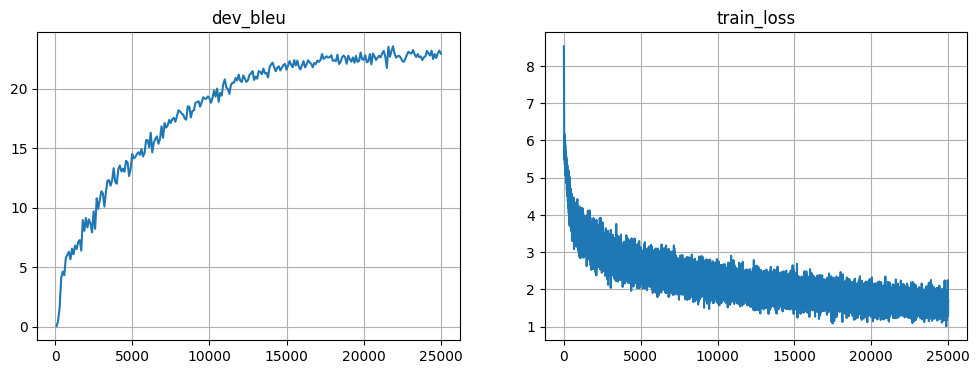

Mean loss=1.585


100%|██████████| 25000/25000 [53:46<00:00,  7.75it/s]


In [ ]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


In [ ]:
compute_bleu(model, dev_inp, dev_out)

22.966888722528044

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в ванной комнате с ванной предоставляется фен .
the bathroom comes with a bathtub and a hairdryer .

на территории можно сыграть в дартс и сквош .
there is also a swing and a sandpit .

апартаменты располагают гостиной зоной .
the apartment will provide you with a seating area .

гости могут самостоятельно приготовить блюда на полностью укомплектованной кухне .
guests can prepare meals in the fully equipped kitchen .

к услугам гостей 2 спальни и 1 ванная комната с ванной и / или душем , а также кухня с духовкой и микроволновой печью .
there are two bedrooms and a bathroom with a bath or shower and a microwave .

ужин для гостей приготовят в ресторане ron@@ ni@@ e ' s w@@ ing@@ s & o@@ y@@ st@@ er bar .
the restaurant at the gästehaus nal@@ nier ’ s restaurant serves a hearty buffet - style rooms .



# Гипотезы

Попробую улучшить качество модели, проверив следующие гипотезы:\
(ниже приведен только измененный код и код обучения)

## 1.Изменение размера словаря / предобработки во время токенизации

In [15]:
def tokenize(x):
    x = re.sub(r'\s+', ' ', x).lower()
    return ' '.join(tokenizer.tokenize(x))

Изменил предобработку во время токенизации, добавив удаление лишних пробелов.

100%|██████████| 16000/16000 [00:23<00:00, 677.21it/s]


inp: этот отель находится в центре парижа , в 2 минутах от площади республики и станции метро с 5 лини@@ ями метро и 4 автобус@@ ными маршру@@ тами .
out: this hotel is located in the centre of paris , 2 minutes from place de la république and its metro station , which offers 5 metro lines and 4 bus lines .

inp: на полностью оборудованной мини - кухне можно самостоятельно готовить .
out: there is a full kitchenette where guests are welcome to prepare their meals .

inp: номера находятся под крышей или на ниж@@ них этажах с эр@@ ке@@ рами с видом на сад .
out: set under the roof or on the lower floors with bay windows looking out onto the park , they are all equipped with wi - fi access .

lines
[np.str_('гостевой дом r .'), np.str_('имеется балкон .'), np.str_('до туапсе 19 км .'), np.str_('до афин — 20 км .'), np.str_('работает боулинг .')]

words to ids (0 = bos, 1 = eos):
tensor([[    0,  5518,  5992,  2475,    29,     1,     1,     1],
        [    0,  6850,  4003,    29,     1,  

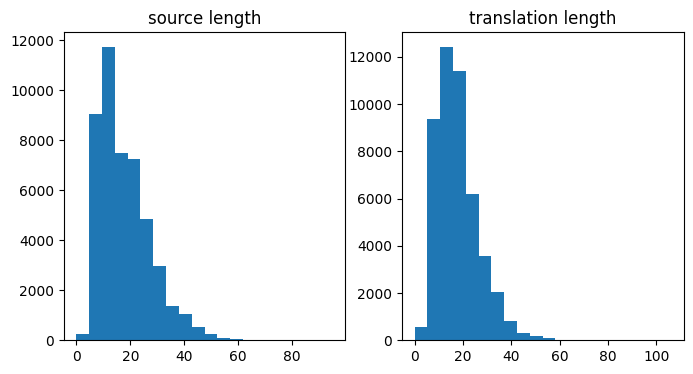

In [16]:
train_inp, dev_inp, train_out, dev_out, inp_voc, out_voc = process_data(num_symbols=16000)

Увеличил размер словаря в 2 раза (с 8000 до 16000)

In [17]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

In [21]:
model

AttentiveModel(
  (emb_inp): Embedding(15385, 64)
  (emb_out): Embedding(14431, 64)
  (enc0): LSTM(64, 128, num_layers=2, batch_first=True)
  (dec_start): Linear(in_features=128, out_features=128, bias=True)
  (dec0): GRUCell(192, 128)
  (logits): Linear(in_features=128, out_features=14431, bias=True)
  (attention): AttentionLayer(
    (linear_enc): Linear(in_features=128, out_features=128, bias=True)
    (linear_dec): Linear(in_features=128, out_features=128, bias=True)
    (linear_out): Linear(in_features=128, out_features=1, bias=True)
    (softmax): Softmax(dim=-1)
  )
)

In [18]:
compute_bleu(model, dev_inp, dev_out)

0.0017868431995143015

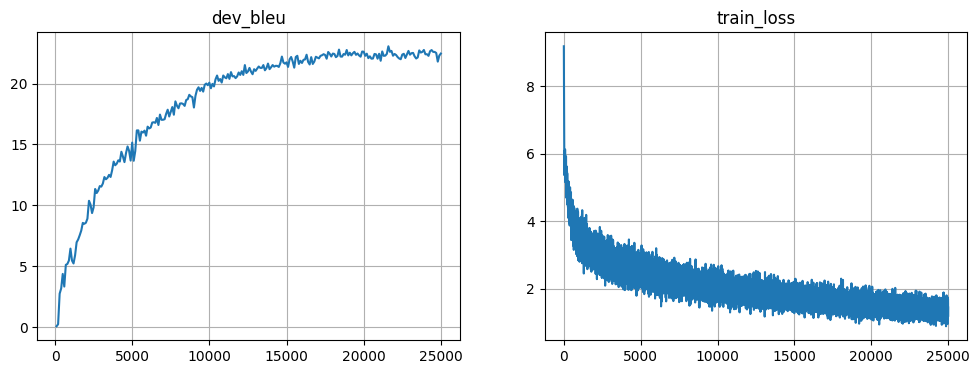

Mean loss=1.433


100%|██████████| 25000/25000 [56:54<00:00,  7.32it/s]


In [19]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


In [20]:
compute_bleu(model, dev_inp, dev_out)

22.473697008261542

## 2.Эксперименты с различными RNN юнитами в encoder и decoder части

In [18]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        super().__init__()
        self.enc_size = enc_size
        self.dec_size = dec_size
        self.hid_size = hid_size

        # Учитываем, что enc_size = 2 * hid_size (из-за bidirectional GRU)
        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        batch_size, ninp, enc_size = enc.shape
        enc_transformed = self.linear_enc(enc)  # [batch_size, ninp, hid_size]
        dec_transformed = self.linear_dec(dec).unsqueeze(1)  # [batch_size, 1, hid_size]
        logits = self.linear_out(torch.tanh(enc_transformed + dec_transformed))  # [batch_size, ninp, 1]
        logits = logits.squeeze(-1)  # [batch_size, ninp]
        logits[~inp_mask] = -1e9
        probs = self.softmax(logits)  # [batch_size, ninp]
        attn = (probs.unsqueeze(-1) * enc).sum(dim=1)  # [batch_size, enc_size]
        attn = self.linear_enc(attn)  # [batch_size, hid_size]

        return attn, probs

In [19]:
class AttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        # Используем GRU вместо LSTM, с одним слоем и bidirectional=True
        self.enc0 = nn.GRU(emb_size, hid_size, num_layers=1, batch_first=True, bidirectional=True)

        # Поскольку GRU двунаправленный, выходной размер скрытого состояния будет 2 * hid_size
        self.dec_start = nn.Linear(2 * hid_size, hid_size)

        # Размерность входных данных для GRUCell: emb_size (эмбеддинг) + hid_size (attention response)
        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attention = AttentionLayer(2 * hid_size, hid_size, attn_size)  # Учтем, что enc_seq теперь имеет размер 2 * hid_size

    def encode(self, inp, **flags):
        inp_emb = self.emb_inp(inp)
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)

        # Поскольку GRU двунаправленный, last_state_but_not_really имеет размер [2, batch_size, hid_size]
        # Мы объединяем forward и backward состояния
        last_state = torch.cat([last_state_but_not_really[0], last_state_but_not_really[1]], dim=-1)

        dec_start = self.dec_start(last_state)

        inp_mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)

        first_state = [dec_start, enc_seq, inp_mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)

        x = self.emb_out(prev_tokens)  # [batch_size, emb_size]
        x = torch.cat([attn, x], dim=-1)  # [batch_size, hid_size + emb_size]

        # Проверяем размерности
        if x.size(-1) != self.dec0.input_size:
            raise ValueError(f"Input size mismatch: expected {self.dec0.input_size}, got {x.size(-1)}")

        x = self.dec0(x, prev_gru0_state)

        new_dec_state = [x, enc_seq, enc_mask, attn_probs]
        output_logits = self.logits(x)
        return [new_dec_state, output_logits]

Заменил LSTM на GRU, изменил количество слоев, использовал bidirectional RNN.

In [20]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

In [21]:
model

AttentiveModel(
  (emb_inp): Embedding(8047, 64)
  (emb_out): Embedding(7800, 64)
  (enc0): GRU(64, 128, batch_first=True, bidirectional=True)
  (dec_start): Linear(in_features=256, out_features=128, bias=True)
  (dec0): GRUCell(192, 128)
  (logits): Linear(in_features=128, out_features=7800, bias=True)
  (attention): AttentionLayer(
    (linear_enc): Linear(in_features=256, out_features=128, bias=True)
    (linear_dec): Linear(in_features=128, out_features=128, bias=True)
    (linear_out): Linear(in_features=128, out_features=1, bias=True)
    (softmax): Softmax(dim=-1)
  )
)

In [22]:
compute_bleu(model, dev_inp, dev_out)

0.0022707958565246463

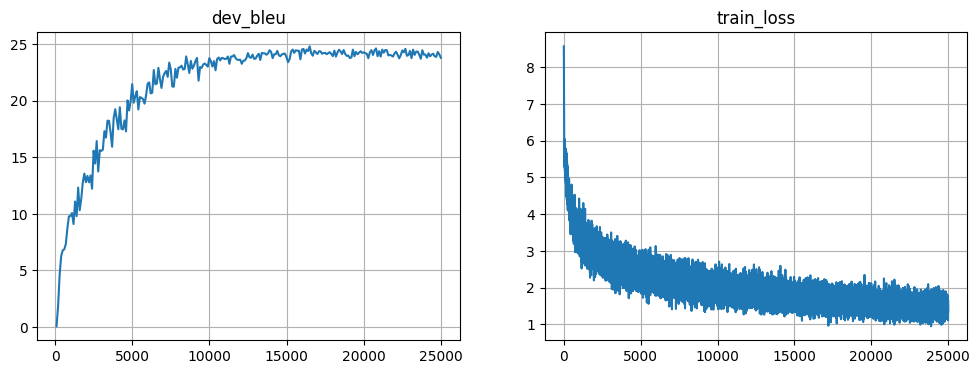

Mean loss=1.421


100%|██████████| 25000/25000 [49:55<00:00,  8.35it/s]


In [23]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

In [24]:
compute_bleu(model, dev_inp, dev_out)

23.81405487841549

## 3.Улучшение процесса тренировки

In [21]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,           # Скорость обучения
    betas=(0.9, 0.999), # Коэффициенты для скользящих средних
    eps=1e-8,          # Стабилизация вычислений
    weight_decay=1e-5, # L2-регуляризация
)
batch_size = 32

In [22]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    mode='max',        # Уменьшаем learning rate, если BLEU не улучшается
    factor=0.5,        # Уменьшаем learning rate в 2 раза
    patience=5         # Ждем 5 шагов без улучшения
)

In [23]:
best_bleu = 0
early_stopping_patience = 5
no_improvement_epochs = 0

In [24]:
model

AttentiveModel(
  (emb_inp): Embedding(8047, 64)
  (emb_out): Embedding(7800, 64)
  (enc0): LSTM(64, 128, num_layers=2, batch_first=True)
  (dec_start): Linear(in_features=128, out_features=128, bias=True)
  (dec0): GRUCell(192, 128)
  (logits): Linear(in_features=128, out_features=7800, bias=True)
  (attention): AttentionLayer(
    (linear_enc): Linear(in_features=128, out_features=128, bias=True)
    (linear_dec): Linear(in_features=128, out_features=128, bias=True)
    (linear_out): Linear(in_features=128, out_features=1, bias=True)
    (softmax): Softmax(dim=-1)
  )
)

Добавил lr sheduling, early stopping, изменил параметры оптимизатора.

In [25]:
compute_bleu(model, dev_inp, dev_out)

0.0021073072989330035

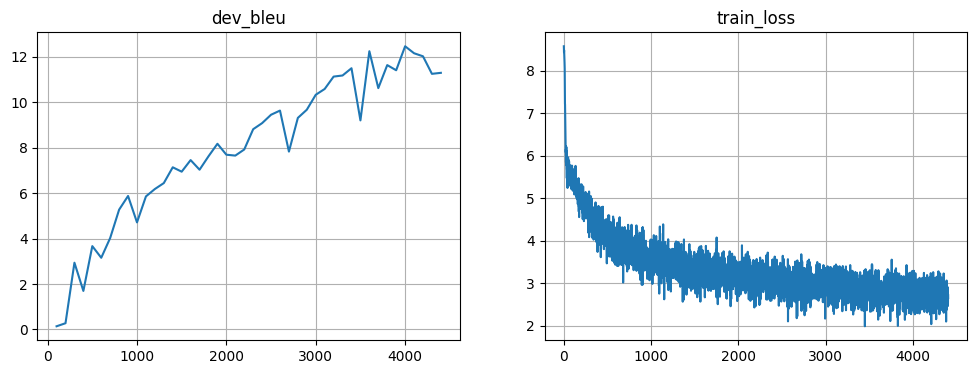

Mean loss=2.665


 18%|█▊        | 4499/25000 [08:42<39:43,  8.60it/s]  

Early stopping at step 4500 with best BLEU 12.460


<All keys matched successfully>

In [26]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        dev_bleu = compute_bleu(model, dev_inp, dev_out)
        metrics['dev_bleu'].append((step, dev_bleu))
        scheduler.step(dev_bleu)  # Обновляем learning rate на основе BLEU

        # Ранняя остановка
        if dev_bleu > best_bleu:
            best_bleu = dev_bleu
            no_improvement_epochs = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Сохраняем лучшую модель
        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= early_stopping_patience:
            print(f"Early stopping at step {step} with best BLEU {best_bleu:.3f}")
            break

        clear_output(True)
        plt.figure(figsize=(12, 4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

# Загружаем лучшую модель
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

In [27]:
compute_bleu(model, dev_inp, dev_out)

12.459803628312168

## 4.Эксперимент с сэмплированием

In [ ]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, last_state_but_not_really = self.enc0(inp_emb)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        prev_gru0_state = prev_state[0]
        prev_emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(prev_emb, prev_gru0_state)
        output_logits = self.logits(new_dec_state)

        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state

        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, temperature=1.0, **flags):
        device = initial_state[1].device
        batch_size = initial_state[1].shape[0]

        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]

        for i in range(max_len):
            prev_tokens = outputs[-1]
            state, logits = self.decode_step(state, prev_tokens, **flags)

            # Применяем температурное масштабирование
            logits = logits / temperature

            # Преобразуем логиты в вероятности
            probabilities = torch.softmax(logits, dim=-1)

            # Сэмплируем следующий токен
            sampled_tokens = torch.multinomial(probabilities, num_samples=1).squeeze(-1)
            outputs.append(sampled_tokens)

            if all(torch.any(out == self.out_voc.eos_ix) for out in outputs):
                break

        return torch.stack(outputs, dim=1), state

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


Заменил greedy-инференс на сэмплирование с температурой.

In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

In [ ]:
model

AttentiveModel(
  (emb_inp): Embedding(8047, 64)
  (emb_out): Embedding(7800, 64)
  (enc0): LSTM(64, 128, num_layers=2, batch_first=True)
  (dec_start): Linear(in_features=128, out_features=128, bias=True)
  (dec0): GRUCell(192, 128)
  (logits): Linear(in_features=128, out_features=7800, bias=True)
  (attention): AttentionLayer(
    (linear_enc): Linear(in_features=128, out_features=128, bias=True)
    (linear_dec): Linear(in_features=128, out_features=128, bias=True)
    (linear_out): Linear(in_features=128, out_features=1, bias=True)
    (softmax): Softmax(dim=-1)
  )
)

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.0020633142012208075

In [ ]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


In [ ]:
compute_bleu(model, dev_inp, dev_out)

# Вывод

В рамках данного задания была проведена серия экспериментов по улучшению качества модели машинного перевода. Основные гипотезы, которые проверялись, включали изменение размера словаря, эксперименты с архитектурой RNN, улучшение процесса обучения и использование различных методов сэмплирования. Результаты экспериментов представлены ниже.

**0. Базовый вариант (LSTM + GRUCell + Attention + жадное сэмплирование + 8_000 размер словаря + Adam):**

`BLEU: 22.9669`

**1. Увеличение размера словаря до 16_000 (LSTM + GRUCell + Attention + жадное сэмплирование + 16_000 размер словаря + Adam):**

`BLEU: 22.4737`

> Увеличение размера словаря не привело к улучшению качества. Возможно, это связано с переобучением на редких токенах.

**2. Использование двунаправленного GRU в энкодере (GRU (bidirectional=True) + GRUCell + Attention + жадное сэмплирование + 8_000 размер словаря + Adam):**

`BLEU: 23.8141`

> Двунаправленный GRU показал лучшее качество по сравнению с LSTM. Это может быть связано с тем, что двунаправленный GRU лучше учитывает контекст входных данных.

**3. Оптимизация процесса обучения (LSTM + GRUCell + Attention + жадное сэмплирование + 8_000 размер словаря + Adam с измененными параметрами + scheduler + early stopping):**

`BLEU: 12.4598`

> Качество модели значительно снизилось по сравнению с базовым вариантом. Это может быть связано с неправильной настройкой параметров оптимизатора или learning rate при использовании scheduler. Возможно, early stopping сработало слишком рано, прервав обучение до того, как модель успела достичь оптимальных значений.

**4. Использование сэмплирования с температурой (LSTM + GRUCell + Attention + сэмплирование с температурой + 8_000 размер словаря + Adam):**

`BLEU: `

> 